<a href="https://colab.research.google.com/github/ammarshibani/data-analysis-colab/blob/main/ESHealthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train_data = pd.read_csv('Training.csv')
test_data = pd.read_csv('Testing.csv')

# Display dataset preview
print("Training Data Preview:")
print(train_data.head())
print("\nTesting Data Preview:")
print(test_data.head())

# Basic dataset information
print("\nTraining Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)

Training Data Preview:
   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  scurring  \
0       0           0             0        0                 0  ...         0   
1       0           0             0        0                 0  ...         0   
2       0           0             0        0                 0  ...         0   
3       0           0             0        0                 0  ...         0   
4       0           0             0        0                 0  ...         0   

   skin_peeling

In [ ]:
# Step 2: Data Cleaning and Preprocessing
# ---------------------------------------

# Remove unnamed column from training data
train_data = train_data.drop('Unnamed: 133', axis=1)

# Combine datasets temporarily for consistent cleaning
combined_data = pd.concat([train_data, test_data], axis=0)

# Handle missing values (fill with 0 for symptom columns)
combined_data = combined_data.fillna(0)

# Remove duplicate rows
combined_data = combined_data.drop_duplicates()

# Separate features and target variable
X = combined_data.iloc[:, :-1]  # All symptoms
y = combined_data['prognosis']  # Target disease

# Check unique diseases
print("\nUnique Diseases in Training:", len(train_data['prognosis'].unique()))
print("Unique Diseases in Testing:", len(test_data['prognosis'].unique()))
print("\nCommon Diseases in Both Sets:", len(set(train_data['prognosis']).intersection(set(test_data['prognosis']))))

# Split back into train/test sets
train_data = combined_data.iloc[:len(train_data)]
test_data = combined_data.iloc[len(train_data):]

# Encode target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_data['prognosis'])
y_test = le.transform(test_data['prognosis'])

print("\nAfter Cleaning:")
print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)
print("Sample Encoded Diagnosis:", y_train[:5])


Unique Diseases in Training: 41
Unique Diseases in Testing: 41

Common Diseases in Both Sets: 41

After Cleaning:
Training Data Shape: (305, 133)
Testing Data Shape: (0, 133)
Sample Encoded Diagnosis: [15 15 15 15 15]


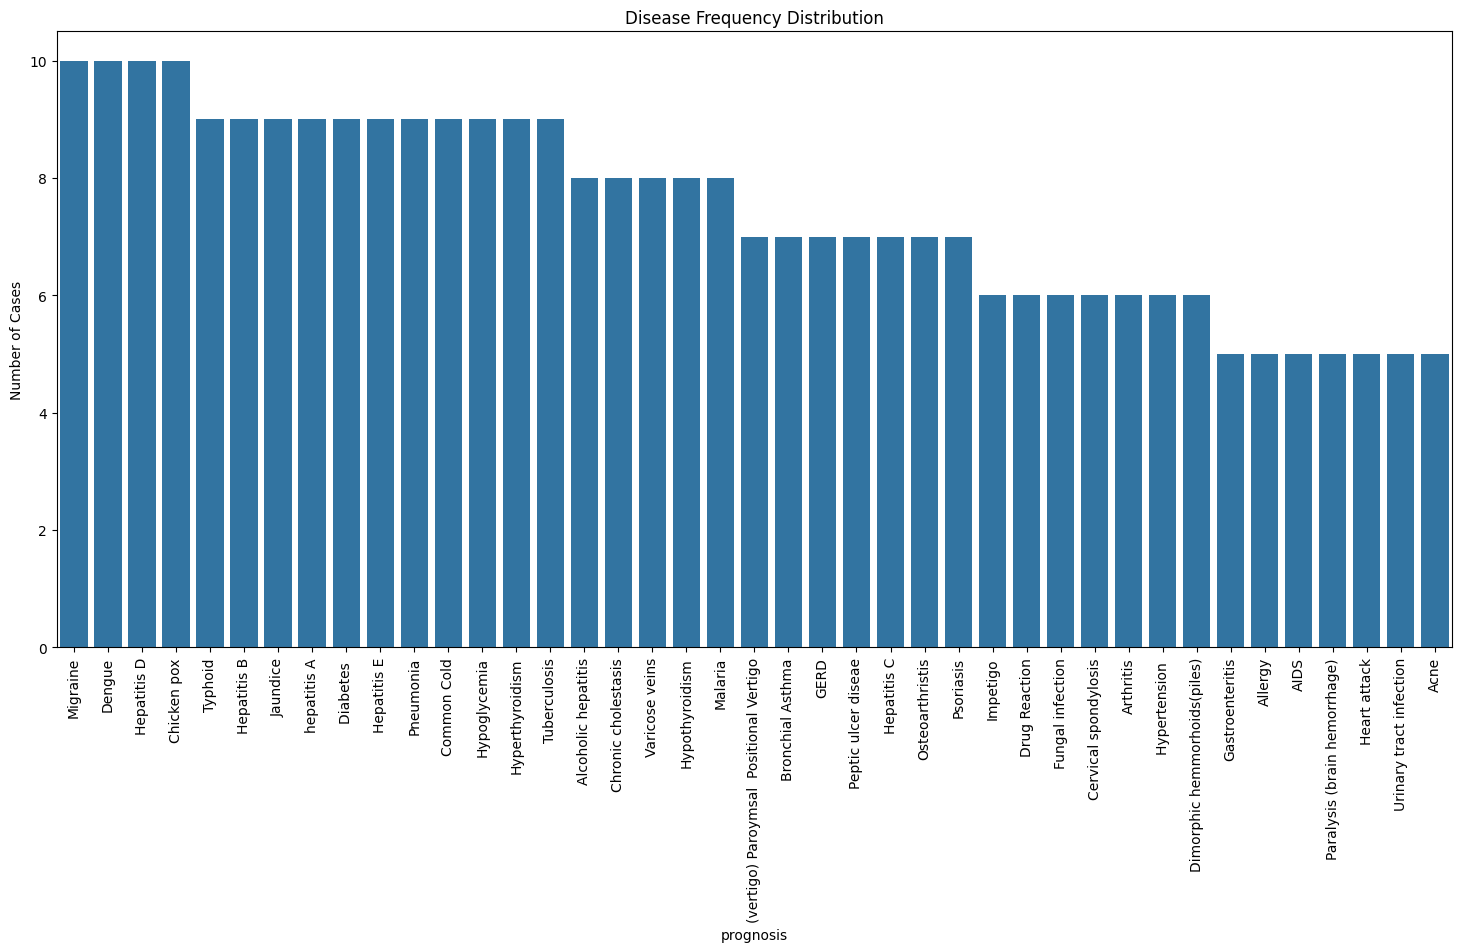

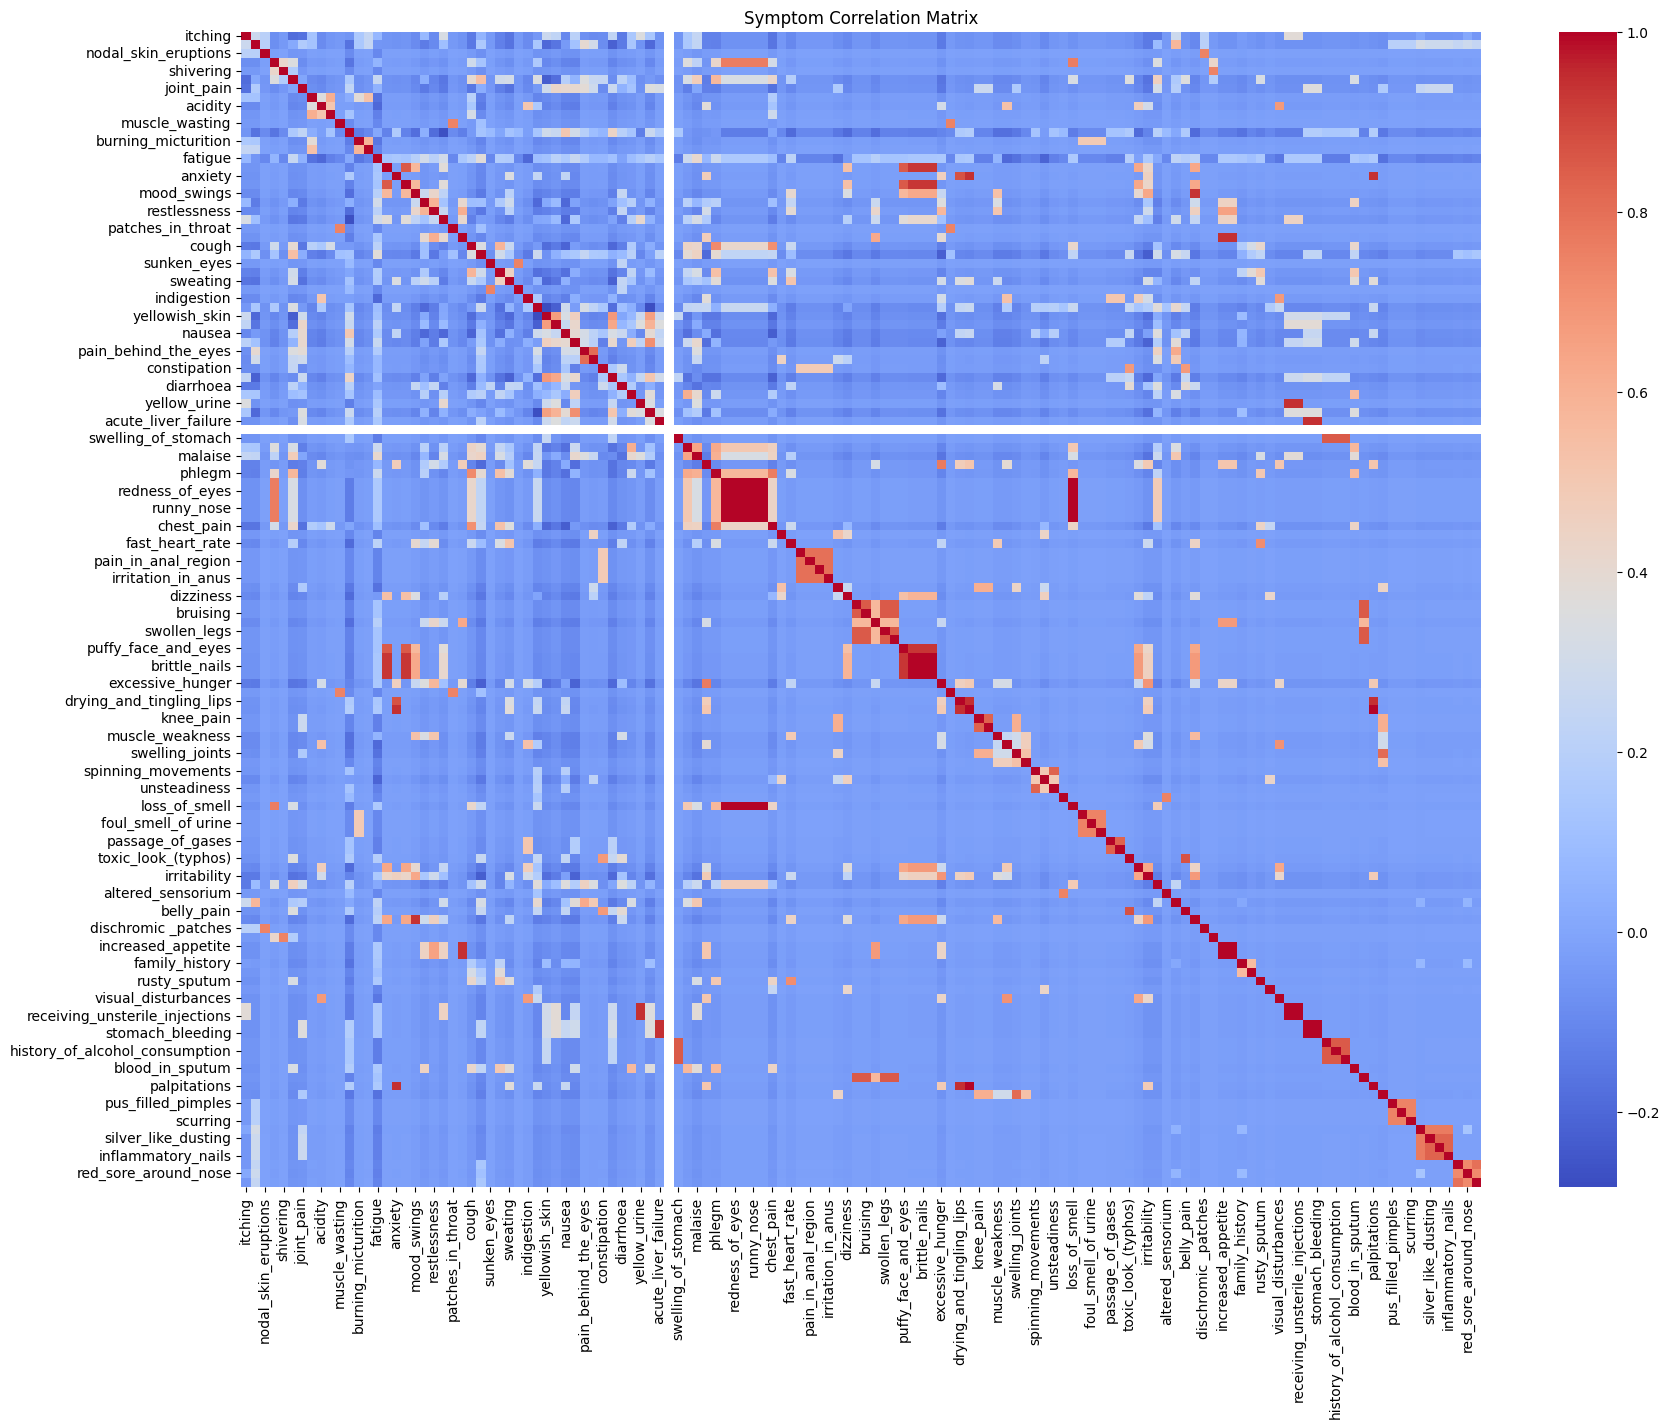

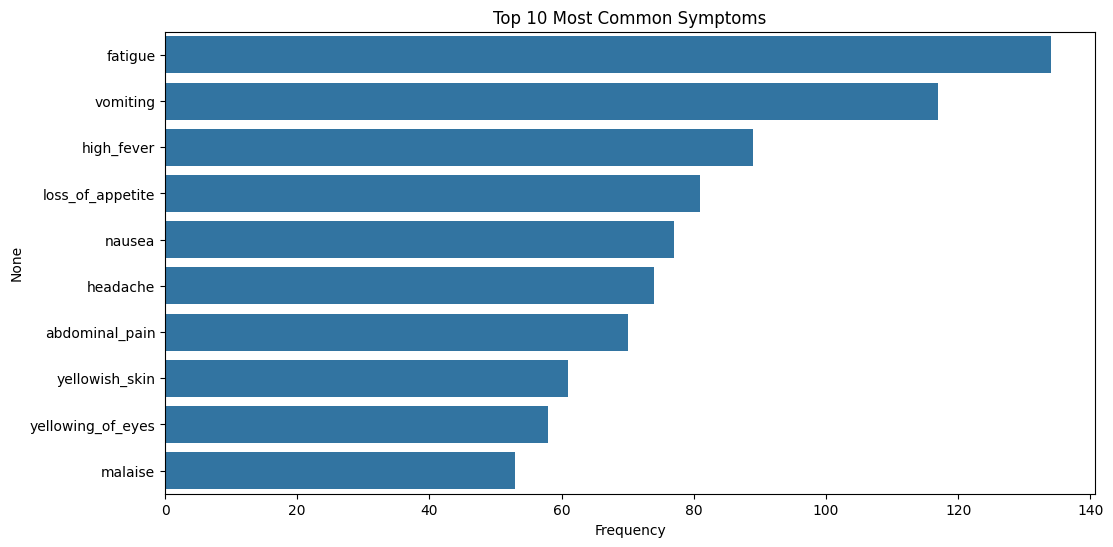


Top Symptoms for Migraine:
blurred_and_distorted_vision    9
headache                        9
indigestion                     9
acidity                         9
visual_disturbances             9
dtype: int64


In [ ]:
# Step 3: Exploratory Data Analysis
# ---------------------------------

# Create distribution plot for diseases
plt.figure(figsize=(18, 8))
disease_counts = pd.Series(y).value_counts()
sns.barplot(x=disease_counts.index, y=disease_counts.values)
plt.xticks(rotation=90)
plt.title('Disease Frequency Distribution')
plt.ylabel('Number of Cases')
plt.show()

# Analyze symptom correlations
plt.figure(figsize=(20, 15))
symptom_corr = X.corr()
sns.heatmap(symptom_corr, cmap='coolwarm')
plt.title('Symptom Correlation Matrix')
plt.show()

# Top 10 most common symptoms
top_symptoms = X.sum().sort_values(ascending=False)[:10]
plt.figure(figsize=(12, 6))
sns.barplot(x=top_symptoms.values, y=top_symptoms.index)
plt.title('Top 10 Most Common Symptoms')
plt.xlabel('Frequency')
plt.show()

# Disease-symptom relationship analysis
sample_disease = y.value_counts().index[0]  # Most frequent disease
disease_symptoms = X[y == sample_disease].sum().sort_values(ascending=False)[:5]

print(f"\nTop Symptoms for {sample_disease}:")
print(disease_symptoms)

In [ ]:
# Step 5: Final Implementation with Error Handling
# -----------------------------------------------

import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Load and prepare data
train_data = pd.read_csv('Training.csv').drop('Unnamed: 133', axis=1)
test_data = pd.read_csv('Testing.csv')

# Clean and prepare datasets
def prepare_data(df):
    return (
        df.drop_duplicates()
        .fillna(0)
        .pipe(lambda x: (x.iloc[:, :-1], x['prognosis']))
    )

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Enhanced Model Pipeline
medical_pipeline = Pipeline([
    ('feature_selection', SelectKBest(mutual_info_classif, k=30)),  # Increased features
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        min_samples_split=5,
        random_state=42
    ))
])

# Train and evaluate
medical_pipeline.fit(X_train, y_train_enc)

print("Optimized Performance:")
print(f"Training Accuracy: {accuracy_score(y_train_enc, medical_pipeline.predict(X_train)):.2f}")
print(f"Testing Accuracy: {accuracy_score(y_test_enc, medical_pipeline.predict(X_test)):.2f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test_enc, medical_pipeline.predict(X_test), zero_division=0))

# Save complete expert system
joblib.dump({
    'pipeline': medical_pipeline,
    'encoder': le,
    'symptoms': X_train.columns.tolist(),
    'feature_selector': medical_pipeline.named_steps['feature_selection']
}, 'medical_expert_system_final.pkl')

print("\nSystem successfully saved with all components!")

Optimized Performance:
Training Accuracy: 0.92
Testing Accuracy: 0.93

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       0.50      1.00      0.67         1
          14       0.33      1.00      0.50         1
          15       0.00      0.0

In [ ]:
# Medical Expert System for Disease Diagnosis
# -------------------------------------------

# Import required libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Preprocessing
# ---------------------------------

# Load datasets
train_df = pd.read_csv('Training.csv').drop('Unnamed: 133', axis=1)
test_df = pd.read_csv('Testing.csv')

def preprocess_data(df):
    """Clean and prepare dataset"""
    return (
        df.drop_duplicates()
        .fillna(0)
        .pipe(lambda x: (x.iloc[:, :-1], x['prognosis']))
    )

# Prepare features and targets
X_train, y_train = preprocess_data(train_df)
X_test, y_test = preprocess_data(test_df)

# 2. Label Encoding
# -----------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 3. Feature Selection and Model Pipeline
# ---------------------------------------
medical_pipeline = Pipeline([
    ('feature_selector', SelectKBest(mutual_info_classif, k=30)),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        min_samples_split=5,
        random_state=42
    ))
])

# 4. Model Training
# -----------------
medical_pipeline.fit(X_train, y_train_enc)

# 5. Performance Evaluation
# --------------------------
print("\n=== Model Performance ===")
print(f"Training Accuracy: {accuracy_score(y_train_enc, medical_pipeline.predict(X_train)):.2f}")
print(f"Testing Accuracy: {accuracy_score(y_test_enc, medical_pipeline.predict(X_test)):.2f}")
print("\nClassification Report:")
print(classification_report(y_test_enc, medical_pipeline.predict(X_test), zero_division=0))

# 6. Save Expert System Components
# --------------------------------
joblib.dump({
    'pipeline': medical_pipeline,
    'encoder': le,
    'symptoms': X_train.columns.tolist(),
    'feature_selector': medical_pipeline.named_steps['feature_selector']
}, 'medical_expert_system.pkl')

# 7. Diagnosis Prediction Function
# --------------------------------
def diagnose(symptoms):
    """Predict disease from symptoms"""
    try:
        # Load saved model
        system = joblib.load('medical_expert_system.pkl')

        # Create symptom vector
        symptom_vector = pd.DataFrame(columns=system['symptoms'], data=np.zeros((1, len(system['symptoms']))))
        for symptom in symptoms:
            if symptom in system['symptoms']:
                symptom_vector[symptom] = 1

        # Feature selection
        selected_features = system['feature_selector'].transform(symptom_vector)

        # Make prediction
        prediction = system['pipeline'].predict(selected_features)
        disease = system['encoder'].inverse_transform(prediction)[0]

        return f"Predicted Diagnosis: {disease}"

    except Exception as e:
        return f"Diagnosis Error: {str(e)}"

# 8. Example Usage
# ----------------
if __name__ == "__main__":
    # Test sample symptoms (blurred vision, headache, vomiting)
    sample_symptoms = ['blurred_and_distorted_vision', 'headache', 'vomiting']
    print("\nExample Diagnosis:")
    print(diagnose(sample_symptoms))


=== Model Performance ===
Training Accuracy: 0.88
Testing Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         1
           7       0.25      1.00      0.40         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         1
          14       0.33      1.00      0.50         1
          15       0.00      0.00    

Loaded 4920 training + 42 testing records
Removed 4657 duplicate records


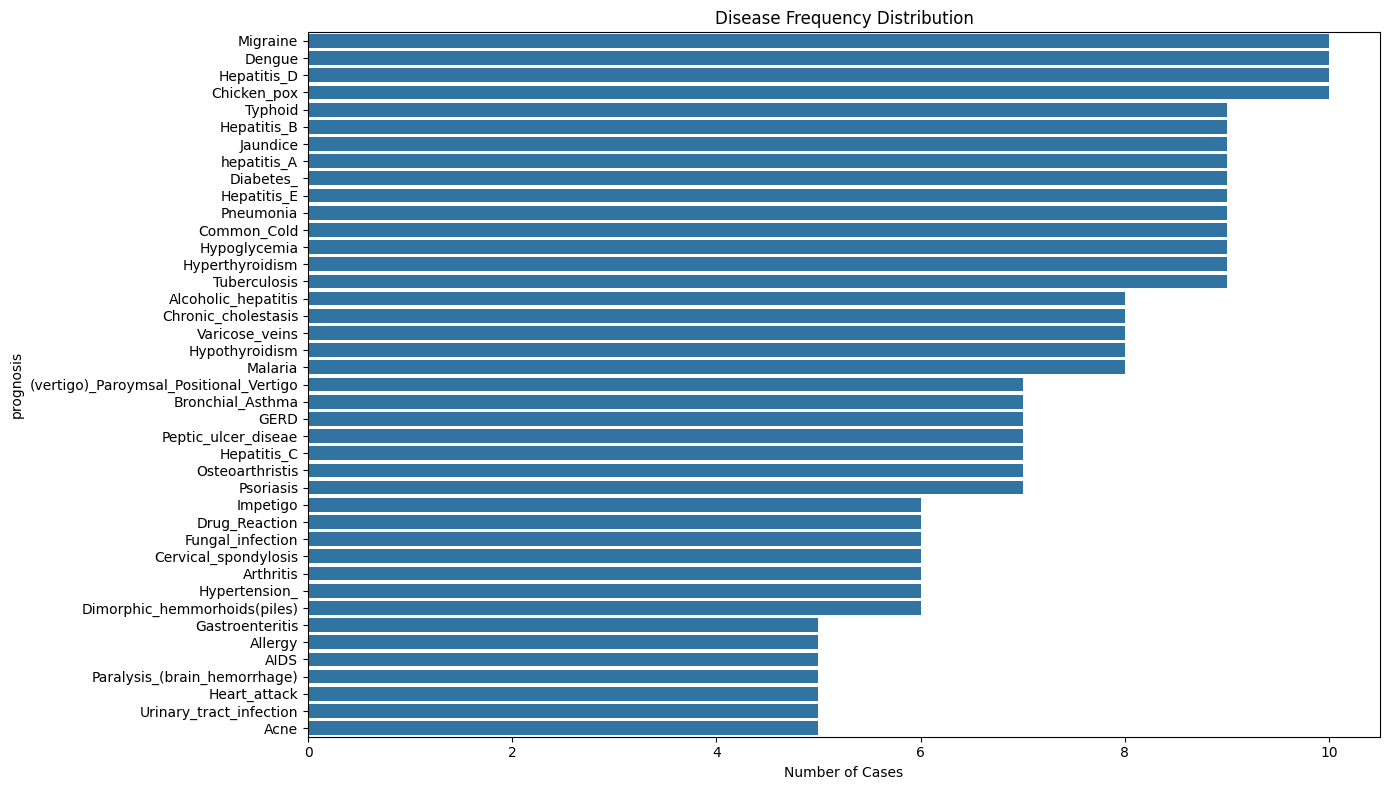

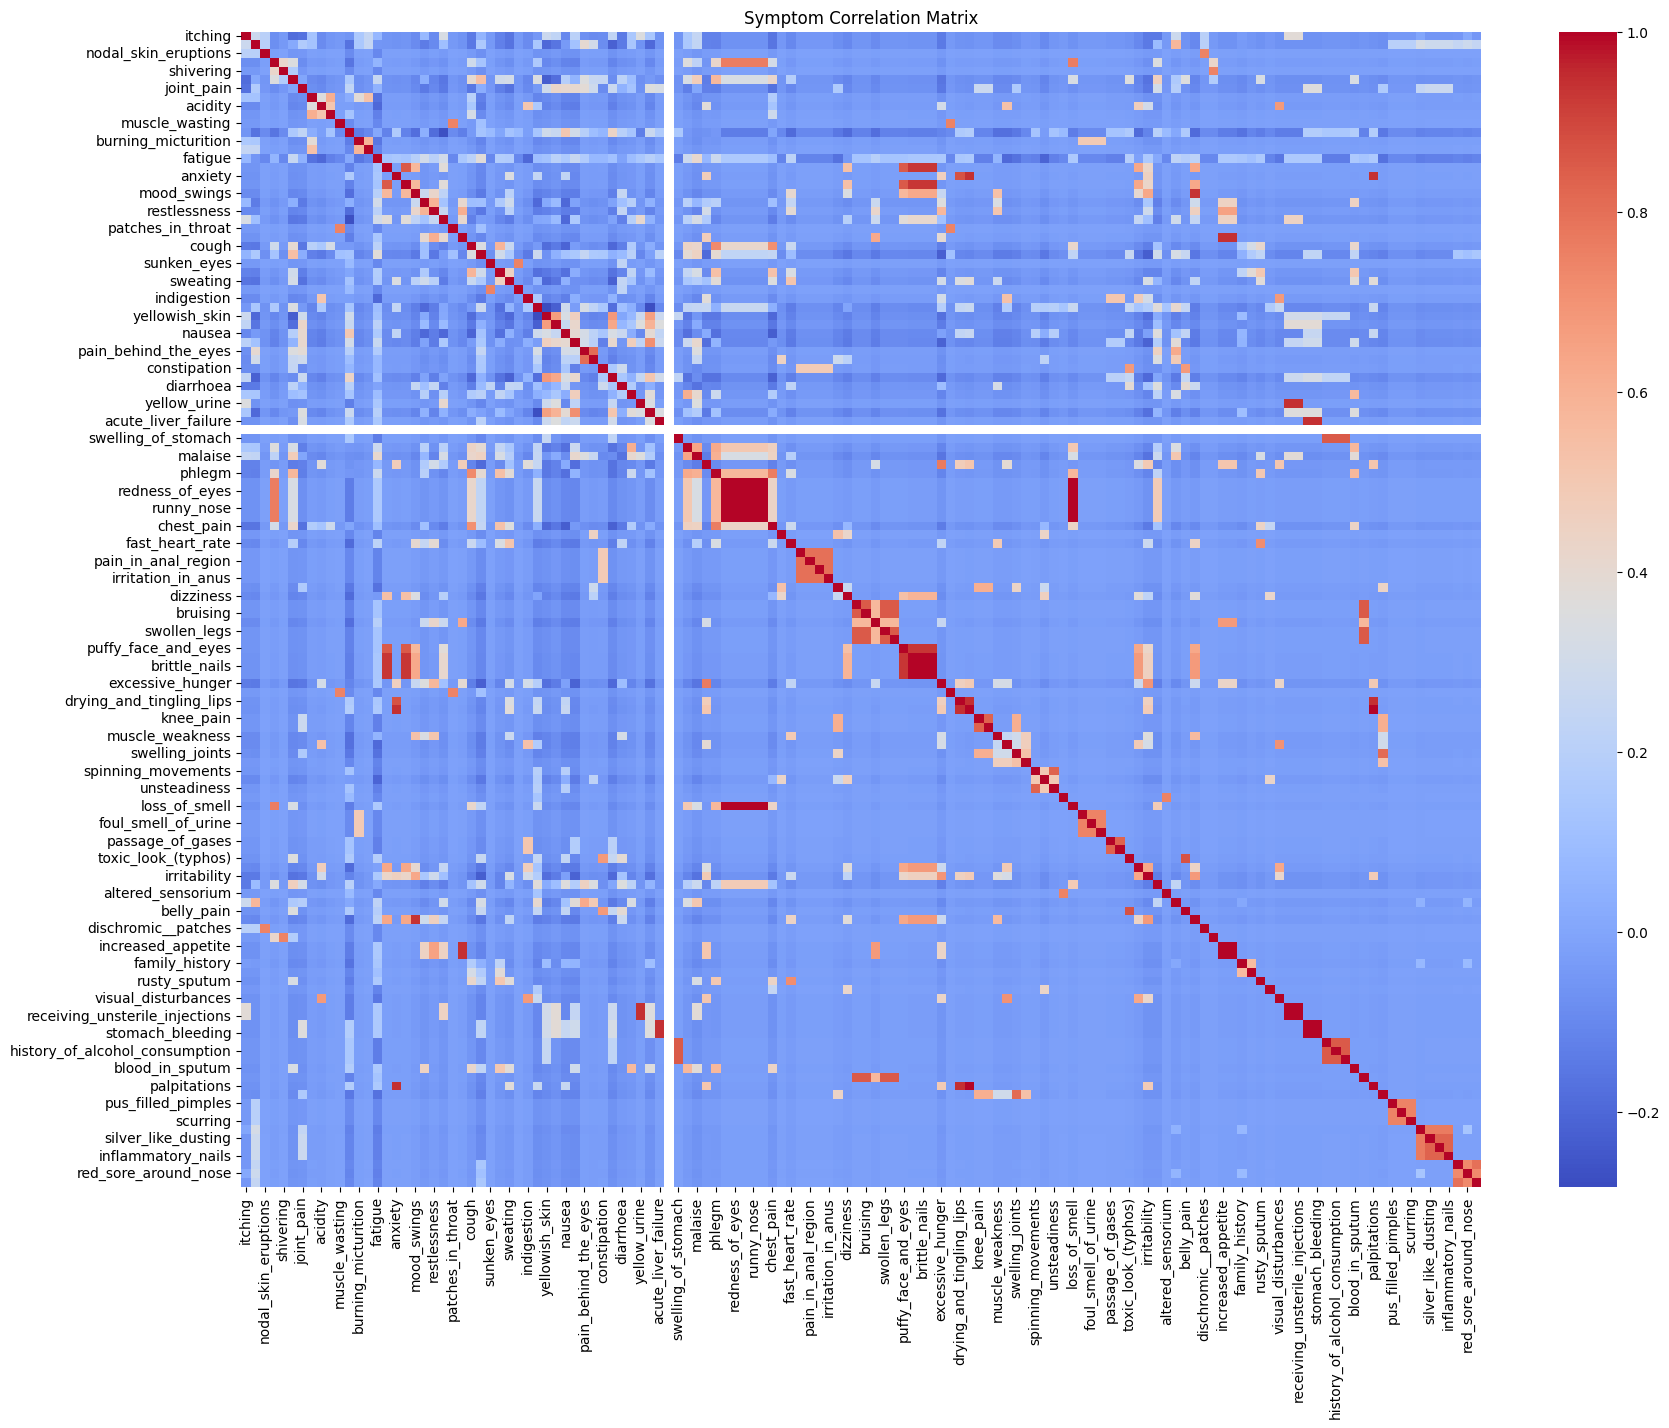

Generated 41 diagnostic rules

Enter symptoms (comma-separated) or 'exit':
> fever, coug, short breath

Diagnostic Results:
1. hepatitis_A (machine-learning)
   Confidence: 0.14

Enter symptoms (comma-separated) or 'exit':
> fever, coug

Diagnostic Results:
1. hepatitis_A (machine-learning)
   Confidence: 0.14

Enter symptoms (comma-separated) or 'exit':
> fever, cough, shortness of breath

Diagnostic Results:
1. hepatitis_A (machine-learning)
   Confidence: 0.14

Enter symptoms (comma-separated) or 'exit':
>  headache, nausea, sensitivity to light

Diagnostic Results:
1. (vertigo)_Paroymsal_Positional_Vertigo (machine-learning)
   Confidence: 0.33
2. Hypertension_ (machine-learning)
   Confidence: 0.15
3. Paralysis_(brain_hemorrhage) (machine-learning)
   Confidence: 0.13

Enter symptoms (comma-separated) or 'exit':
> high blood sugar, frequent urination, increased thirst

Diagnostic Results:
1. Diabetes_ (machine-learning)
   Confidence: 0.23

Enter symptoms (comma-separated) or 'exi

In [ ]:
import pandas as pd
import numpy as np
import difflib
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# ----------------------------
# 1. Enhanced Data Integration
# ----------------------------
def load_and_combine_data():
    """Load and combine training/testing datasets"""
    try:
        train = pd.read_csv("Training.csv").drop('Unnamed: 133', axis=1)
        test = pd.read_csv("Testing.csv")
        combined = pd.concat([train, test], axis=0)
        print(f"Loaded {len(train)} training + {len(test)} testing records")
        return combined
    except Exception as e:
        print(f"Data loading error: {str(e)}")
        return None

# ----------------------------
# 2. Advanced Data Processing
# ----------------------------
def preprocess_data(df):
    """Enhanced cleaning and normalization"""
    # Handle missing values
    df = df.fillna(0).replace({'prognosis': r'\s+'}, {'prognosis': '_'}, regex=True)

    # Remove duplicates
    initial = len(df)
    df = df.drop_duplicates()
    print(f"Removed {initial - len(df)} duplicate records")

    # Symptom standardization
    df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
    return df

# ----------------------------
# 3. Comprehensive EDA
# ----------------------------
def perform_eda(df):
    """Generate detailed analytics and visualizations"""
    # Disease distribution
    plt.figure(figsize=(14,8))
    disease_counts = df['prognosis'].value_counts()
    sns.barplot(y=disease_counts.index, x=disease_counts.values)
    plt.title('Disease Frequency Distribution')
    plt.xlabel('Number of Cases')
    plt.tight_layout()
    plt.show()

    # Symptom correlation matrix
    plt.figure(figsize=(20,15))
    corr = df.iloc[:,:-1].corr()
    sns.heatmap(corr, cmap='coolwarm')
    plt.title('Symptom Correlation Matrix')
    plt.show()

# ----------------------------
# 4. Dynamic Rule Generation
# ----------------------------
def generate_diagnostic_rules(df, min_symptoms=3):
    """Automatically generate diagnostic rules from data"""
    rules = []
    diseases = df['prognosis'].unique()

    for disease in diseases:
        disease_data = df[df['prognosis'] == disease]
        symptoms = disease_data.iloc[:, :-1].sum().sort_values(ascending=False)
        common_symptoms = symptoms[symptoms > symptoms.quantile(0.75)].index.tolist()

        if len(common_symptoms) >= min_symptoms:
            rules.append({
                'disease': disease,
                'symptoms': set(common_symptoms[:5]),  # Top 5 symptoms
                'confidence': symptoms.mean() / disease_data.shape[0]
            })

    print(f"Generated {len(rules)} diagnostic rules")
    return rules

# ----------------------------
# 5. Intelligent Symptom Mapping
# ----------------------------
class SymptomMapper:
    """Handles symptom validation and fuzzy matching"""
    def __init__(self, valid_symptoms):
        self.valid_symptoms = valid_symptoms

    def map_symptoms(self, inputs):
        """Fuzzy match input symptoms to known symptoms"""
        matched = []
        for symptom in inputs:
            matches = difflib.get_close_matches(
                symptom.lower(),
                self.valid_symptoms,
                n=1,
                cutoff=0.6
            )
            if matches:
                matched.append(matches[0])
        return list(set(matched))

# ----------------------------
# 6. Hybrid Diagnostic System
# ----------------------------
class MedicalExpertSystem:
    def __init__(self, rules, model, mapper, encoder):
        self.rules = rules
        self.model = model
        self.mapper = mapper
        self.encoder = encoder

    def diagnose(self, symptoms):
        """Combined rule-based and ML diagnosis"""
        # Clean and map symptoms
        cleaned = self.mapper.map_symptoms(symptoms)

        # Rule-based diagnosis
        rule_results = []
        for rule in self.rules:
            if rule['symptoms'].issubset(cleaned):
                rule_results.append({
                    'disease': rule['disease'],
                    'confidence': rule['confidence'],
                    'type': 'rule-based'
                })

        # ML-based diagnosis
        ml_input = pd.DataFrame(
            columns=self.mapper.valid_symptoms,
            data=np.zeros((1, len(self.mapper.valid_symptoms))))
        for s in cleaned:
            if s in ml_input.columns:
                ml_input[s] = 1

        ml_proba = self.model.predict_proba(ml_input)[0]
        top_ml = np.argsort(-ml_proba)[:3]  # Top 3 predictions

        ml_results = [{
            'disease': self.encoder.inverse_transform([idx])[0],
            'confidence': float(ml_proba[idx]),
            'type': 'machine-learning'
        } for idx in top_ml if ml_proba[idx] > 0.1]

        # Combine results
        combined = rule_results + ml_results
        return sorted(combined, key=lambda x: -x['confidence'])

# ----------------------------
# 7. Execution Pipeline
# ----------------------------
def main():
    # Data processing
    df = load_and_combine_data()
    if df is None: return

    processed_df = preprocess_data(df)
    perform_eda(processed_df)

    # Prepare ML components
    X = processed_df.iloc[:, :-1]
    y = processed_df['prognosis']
    le = LabelEncoder().fit(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = RandomForestClassifier().fit(X_train, le.transform(y_train))

    # Generate rules and mapper
    rules = generate_diagnostic_rules(processed_df)
    mapper = SymptomMapper(valid_symptoms=X.columns.tolist())

    # Initialize system
    mes = MedicalExpertSystem(rules, model, mapper, le)

    # Interactive diagnosis
    while True:
        print("\nEnter symptoms (comma-separated) or 'exit':")
        inputs = input("> ").strip().lower()
        if inputs == 'exit': break

        symptoms = [s.strip() for s in inputs.split(',')]
        results = mes.diagnose(symptoms)

        print("\nDiagnostic Results:")
        if not results:
            print("No clear diagnosis. Please consult a specialist.")
            continue

        for i, res in enumerate(results[:3], 1):
            print(f"{i}. {res['disease']} ({res['type']})")
            print(f"   Confidence: {res['confidence']:.2f}")

if __name__ == "__main__":
    main()